# OVERVIEW OF DATASET
**Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.**

**To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.**

**The dataset consists about 28000 text data points where each data category belongs to 2 category - Sarcastic or Not Sarcastic**

**We will use two models for making predictions - Word2Vec and GloVe Embeddings. We will then compare their results and see which performs better**
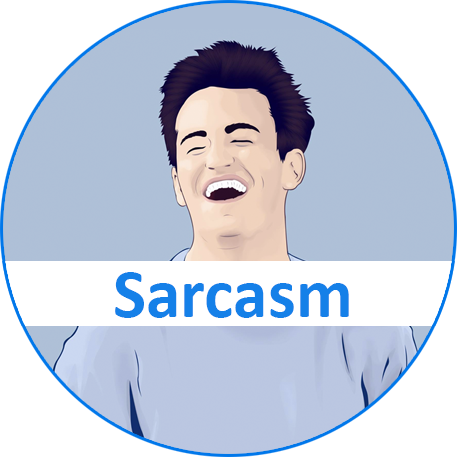

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/glove-twitter/glove.twitter.27B.25d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.50d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.200d.txt
/kaggle/input/glove-twitter/glove.twitter.27B.100d.txt


# LOADING THE NECESSARY LIBRARIES

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf

Using TensorFlow backend.


# LOADING THE DATASET

In [15]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# DATA VISUALIZATION AND PREPROCESSING

In [17]:
df.isna().sum() # Checking for NaN values

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [19]:
del df['article_link'] # Deleting this column as it is of no use

In [20]:
df.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


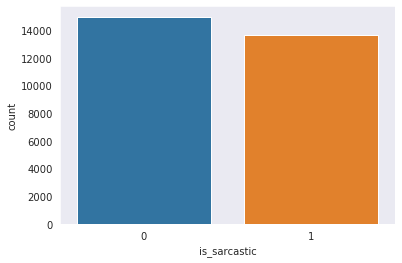

In [21]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [23]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**BASIC DATA CLEANING**

In [24]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
# X=df['headline'].apply(denoise_text)

In [26]:
X = df['headline']

**WORDCLOUD FOR TEXT THAT IS NOT SARCASTIC (LABEL - 0)**

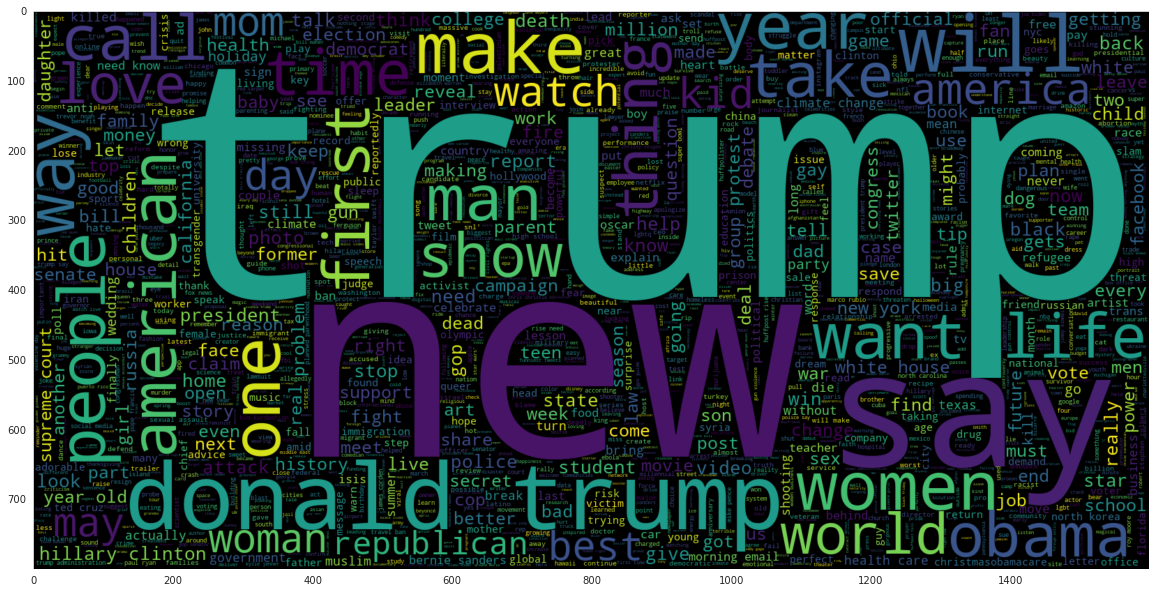

In [29]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR SARCASTIC TEXT (LABEL - 1)**

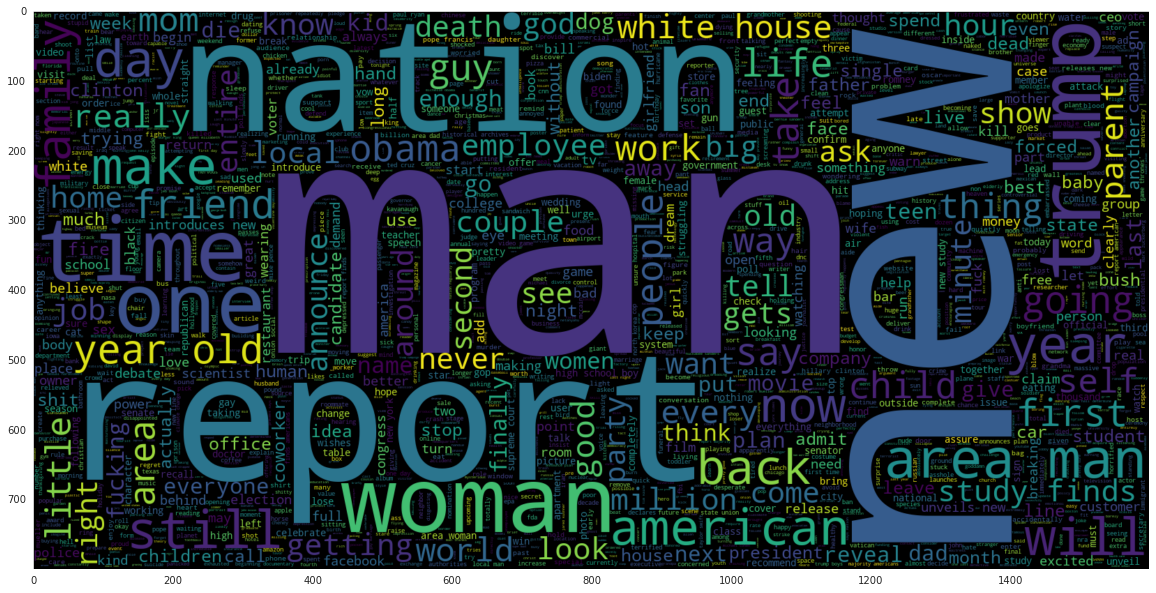

In [28]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

[](http://)**Number of characters in texts**

In [30]:
# number character in texts 
df[df['is_sarcastic']==1]['headline'].str.len().max()

926

In [31]:
df[df['is_sarcastic']==0]['headline'].str.len().max()

228

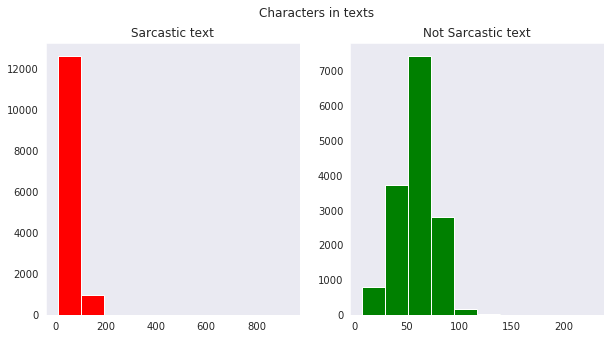

In [32]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

**Number of words in each text**

In [20]:
# number of E-words in each text which have label 1 
df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x)).max()

151

In [21]:
# number of E-words in each text which have label 0
df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x)).max()

38

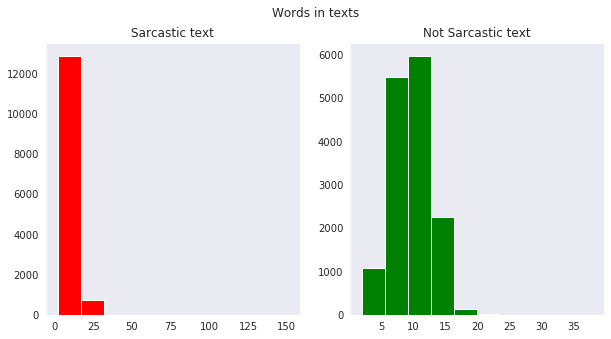

In [22]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

In [33]:
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
word[0]

[15, 10, 6, 8, 5, 2, 4, 4]

Text(0.5, 0.98, 'Average word length in each text')

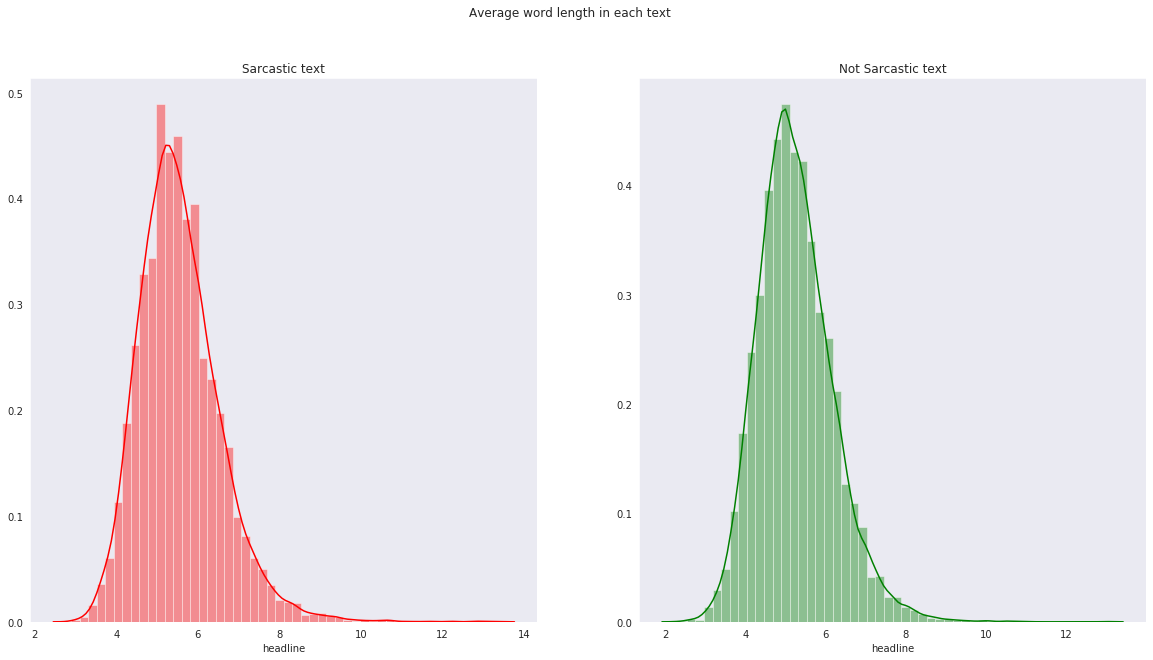

In [34]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

# Introduction to Word Embedding and Word2Vec
**Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.
What are word embeddings exactly? Loosely speaking, they are vector representations of a particular word. Having said this, what follows is how do we generate them? More importantly, how do they capture the context?
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.**

# Why do we need them?
**Consider the following similar sentences: Have a good day and Have a great day. They hardly have different meaning. If we construct an exhaustive vocabulary (let’s call it V), it would have V = {Have, a, good, great, day}.
Now, let us create a one-hot encoded vector for each of these words in V. Length of our one-hot encoded vector would be equal to the size of V (=5). We would have a vector of zeros except for the element at the index representing the corresponding word in the vocabulary. That particular element would be one. The encodings below would explain this better.
Have = [1,0,0,0,0] ; a=[1,0,0,0,0] ; good=[0,0,1,0,0] ; great=[0,0,0,1,0] ; day=[0,0,0,0,1] (represents transpose)
If we try to visualize these encodings, we can think of a 5 dimensional space, where each word occupies one of the dimensions and has nothing to do with the rest (no projection along the other dimensions). This means ‘good’ and ‘great’ are as different as ‘day’ and ‘have’, which is not true.**
**Our objective is to have words with similar context occupy close spatial positions. Mathematically, the cosine of the angle between such vectors should be close to 1, i.e. angle close to 0.**
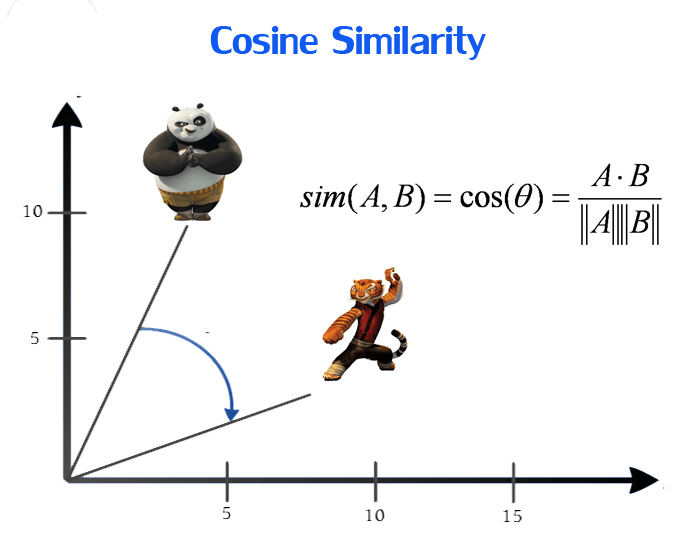
**Here comes the idea of generating distributed representations. Intuitively, we introduce some dependence of one word on the other words. The words in context of this word would get a greater share of this dependence. In one hot encoding representations, all the words are independent of each other, as mentioned earlier.**

**Source Credits : https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa **

**Converting text to format acceptable by gensim**

In [38]:
words = []
for i in df.headline.values:
    words.append(i.split())
words[:5]

[['thirtysomething',
  'scientists',
  'unveil',
  'doomsday',
  'clock',
  'of',
  'hair',
  'loss'],
 ['dem',
  'rep.',
  'totally',
  'nails',
  'why',
  'congress',
  'is',
  'falling',
  'short',
  'on',
  'gender,',
  'racial',
  'equality'],
 ['eat', 'your', 'veggies:', '9', 'deliciously', 'different', 'recipes'],
 ['inclement', 'weather', 'prevents', 'liar', 'from', 'getting', 'to', 'work'],
 ['mother',
  'comes',
  'pretty',
  'close',
  'to',
  'using',
  'word',
  "'streaming'",
  'correctly']]

In [39]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 150 

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences = words , size=EMBEDDING_DIM , window = 7 , min_count = 1)

In [40]:
#vocab size
len(w2v_model.wv.vocab)
#We have now represented each of 38071 words by a 150dim vector.

38234

In [34]:
w2v_model.wv['trump'].shape

(150,)

In [41]:
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = sequence.pad_sequences(tokenized_train, maxlen = 20)

In [42]:
X

0        thirtysomething scientists unveil doomsday clo...
1        dem rep. totally nails why congress is falling...
2        eat your veggies: 9 deliciously different recipes
3        inclement weather prevents liar from getting t...
4        mother comes pretty close to using word 'strea...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg-gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 28619, dtype: object

In [43]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [44]:
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'man': 12,
 'from': 13,
 'at': 14,
 'trump': 15,
 'about': 16,
 'by': 17,
 'after': 18,
 'you': 19,
 'this': 20,
 'be': 21,
 'as': 22,
 'out': 23,
 'that': 24,
 'how': 25,
 'up': 26,
 'it': 27,
 'not': 28,
 'he': 29,
 'his': 30,
 'are': 31,
 'just': 32,
 'your': 33,
 'what': 34,
 'who': 35,
 'has': 36,
 'will': 37,
 'all': 38,
 'into': 39,
 'more': 40,
 'have': 41,
 'one': 42,
 'over': 43,
 'why': 44,
 'area': 45,
 'can': 46,
 'woman': 47,
 'says': 48,
 'donald': 49,
 'report:': 50,
 'u.s.': 51,
 'day': 52,
 'like': 53,
 'get': 54,
 'first': 55,
 'her': 56,
 'time': 57,
 "trump's": 58,
 'no': 59,
 'an': 60,
 'now': 61,
 'people': 62,
 'off': 63,
 'still': 64,
 'house': 65,
 'white': 66,
 'than': 67,
 'was': 68,
 'make': 69,
 'life': 70,
 'if': 71,
 'obama': 72,
 'back': 73,
 'women': 74,
 'my': 75,
 'when': 76,
 'down': 77,
 'could': 78,
 'their': 79,
 'they': 80,
 'bef

In [45]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [47]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [48]:
embedding_vectors.shape

(38235, 150)

# TRAINING WORD2VEC MODEL

In [49]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=20, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

# del embedding_vectors

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 150)           5735250   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 256)           285696    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                55488     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 6,076,499
Trainable params: 6,076,499
Non-trainable params: 0
_________________________________________________________________


In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [56]:
history = model.fit(x_train, y_train, batch_size = 150 , validation_data = (x_test,y_test) , epochs = 10)

Train on 20033 samples, validate on 8586 samples
Epoch 1/10
20033/20033 [==============================] - 28s 1ms/step - loss: 0.0203 - acc: 0.9932 - val_loss: 0.5221 - val_acc: 0.8246
Epoch 2/10
20033/20033 [==============================] - 27s 1ms/step - loss: 0.0126 - acc: 0.9962 - val_loss: 0.6205 - val_acc: 0.8332
Epoch 3/10
20033/20033 [==============================] - 28s 1ms/step - loss: 0.0070 - acc: 0.9975 - val_loss: 0.6737 - val_acc: 0.8078
Epoch 4/10
20033/20033 [==============================] - 27s 1ms/step - loss: 0.0067 - acc: 0.9980 - val_loss: 0.7654 - val_acc: 0.8211
Epoch 5/10
20033/20033 [==============================] - 28s 1ms/step - loss: 0.0056 - acc: 0.9981 - val_loss: 0.7501 - val_acc: 0.8146
Epoch 6/10
20033/20033 [==============================] - 27s 1ms/step - loss: 0.0053 - acc: 0.9983 - val_loss: 0.8317 - val_acc: 0.8146
Epoch 7/10
20033/20033 [==============================] - 28s 1ms/step - loss: 0.0033 - acc: 0.9990 - val_loss: 0.9081 - val_acc:

In [58]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100)

20033/20033 [==============================] - 8s 390us/step
Accuracy of the model on Training Data is -  99.86023306846619
8586/8586 [==============================] - 3s 366us/step
Accuracy of the model on Testing Data is -  81.26019239425659


# ANALYSIS AFTER TRAINING OF WORD2VEC MODEL 

ValueError: x and y must have same first dimension, but have shapes (3,) and (10,)

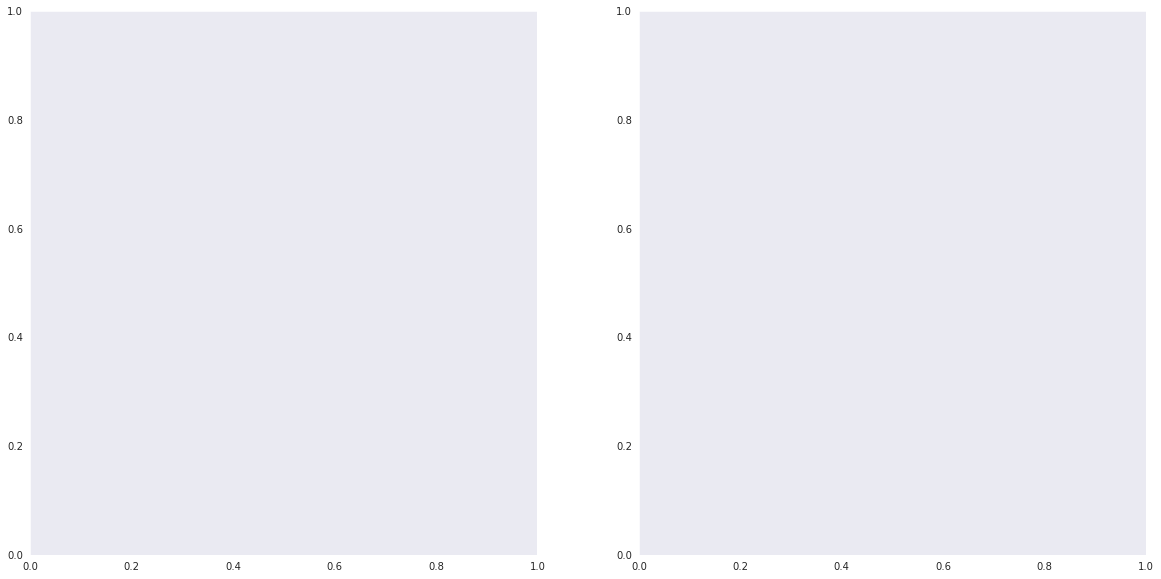

In [63]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

**SEEMS LIKE THE MODEL IS OVERFITTING AND NOT PERFORMING WELL ON THE TEST DATA**

In [64]:
pred = model.predict_classes(x_test)
pred[:5]

array([[1],
       [0],
       [1],
       [0],
       [1]], dtype=int32)

In [66]:
cm = confusion_matrix(y_test,pred)
cm

array([[3692,  868],
       [ 741, 3285]])

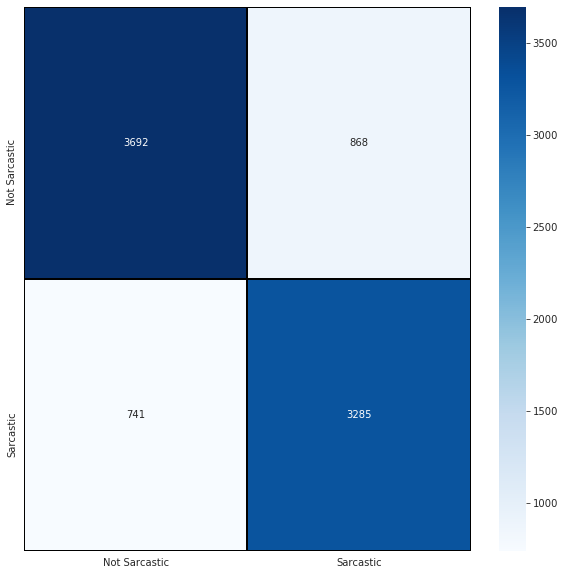

In [67]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

# Introduction to GloVe
**GloVe method is built on an important idea, You can derive semantic relationships between words from the co-occurrence matrix. Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.**
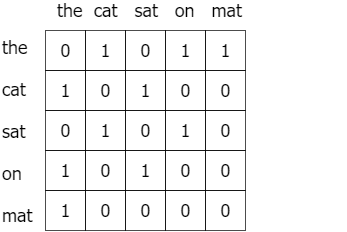
**The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix. How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.**

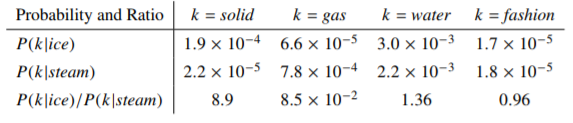
**The behavior of P_ik/P_jk for various words Consider the entity P_ik/P_jk where P_ik = X_ik/X_i Here P_ik denotes the probability of seeing word i and k together, which is computed by dividing the number of times i and k appeared together (X_ik) by the total number of times word i appeared in the corpus (X_i). You can see that given two words, i.e. ice and steam, if the third word k (also called the “probe word”), is very similar to ice but irrelevant to steam (e.g. k=solid), P_ik/P_jk will be very high (>1), is very similar to steam but irrelevant to ice (e.g. k=gas), P_ik/P_jk will be very small (<1), is related or unrelated to either words, then P_ik/P_jk will be close to 1 So, if we can find a way to incorporate P_ik/P_jk to computing word vectors we will be achieving the goal of using global statistics when learning word vectors.**

In [86]:
x_train,x_test,y_train,y_test = train_test_split(df.headline,df.is_sarcastic, test_size = 0.3 , random_state = 0)

In [87]:
max_features = 35000
maxlen = 200

**Tokenizing Text -> Repsesenting each word by a number**

**Mapping of orginal word to number is preserved in word_index property of tokenizer**

**Tokenized applies basic processing like changing it to lower case, explicitely setting that as False**

**Lets keep all news to 200, add padding to news with less than 200 words and truncating long ones**

In [88]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [89]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [90]:
EMBEDDING_FILE = '../input/glove-twitter/glove.twitter.27B.200d.txt'

In [91]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [75]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


**BASIC MODEL PARAMETERS**

In [92]:
batch_size = 128
epochs = 2
embed_size = 150

# TRAINING GLOVE EMBEDDINGS MODEL

In [93]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(nb_words, output_dim=embed_size, weights=[embedding_matrix], input_length=200, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

ValueError: Layer weight shape (25894, 150) not compatible with provided weight shape (25894, 200)

In [ ]:
model.summary()

In [85]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 2)+

Train on 20033 samples, validate on 8586 samples
Epoch 1/2
15232/20033 [=====================>........] - ETA: 38s - loss: 0.2865 - acc: 0.8816

InvalidArgumentError:  indices[117,199] = 25894 is not in [0, 25894)
	 [[node embedding_2/embedding_lookup (defined at /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3009) ]] [Op:__inference_keras_scratch_graph_36313]

Function call stack:
keras_scratch_graph


In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)

**THE ACCURACY IMPROVED FROM 79% TO 83%**

# ANALYSIS AFTER TRAINING OF GLOVE EMBEDDINGS MODEL

In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

In [ ]:
print(classification_report(y_test, pred, target_names = ['Not Sarcastic','Sarcastic']))

In [ ]:
cm = confusion_matrix(y_test,pred)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

**PLS UPVOTE THIS NOTEBOOK IF YOU LIKE IT. THANKS FOR YOUR TIME!**